In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from topostats.io import LoadScans
import topostats.filters as topofilters
from topostats.utils import get_mask
from scipy.optimize import least_squares
from scipy.interpolate import splprep, splev
from scipy.spatial import distance
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion
from scipy import ndimage
from scipy.spatial.distance import cdist
from skimage.morphology import label, remove_small_objects
from skimage.measure import regionprops
from skimage.io import imread
from skimage.color import label2rgb
from topostats.theme import Colormap

In [2]:
cmap = Colormap('nanoscope').get_cmap()

def plot(image: np.ndarray, title: str=None, zlimit: bool=True, figsize: tuple=(8, 8), **kwargs) -> None:
    fig, ax = plt.subplots(figsize=figsize)
    if zlimit == True:
        vmin=-3
        vmax=4
    else:
        vmin=None
        vmax=None
    ax.imshow(image, vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)
    if title is not None:
        ax.set_title(title)
    plt.show()

# Load image and optionally flatten and save (for manual masking)

[Wed, 19 Apr 2023 15:04:31] [INFO    ] [topostats] Extracting image from Folded/20230126_KPN005.0_00026.spm
[Wed, 19 Apr 2023 15:04:31] [INFO    ] [topostats] Loading image from : Folded/20230126_KPN005.0_00026.spm
[Wed, 19 Apr 2023 15:04:31] [INFO    ] [topostats] [20230126_KPN005.0_00026] : Loaded image from : Folded/20230126_KPN005.0_00026.spm
[Wed, 19 Apr 2023 15:04:31] [INFO    ] [topostats] [20230126_KPN005.0_00026] : Extracted channel Height
[Wed, 19 Apr 2023 15:04:31] [INFO    ] [topostats] [20230126_KPN005.0_00026] : Pixel to nm scaling : 5.6396484375


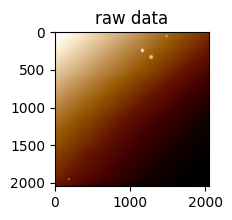

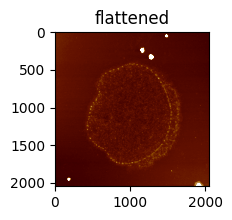

In [3]:
#file = Path('./Folded/20221215_KDNA011.0_00007.spm')
# file = Path('./Folded/20230118_KPN001.0_00007.spm')
#file = Path('./Folded/20230118_KPN001.0_00009.spm')
#file = Path('./Folded/20230118_KPN001.0_00020.spm')
#file = Path('./Folded/20230118_KPN001.0_00027.spm')
#file = Path('./Folded/20230124_KPN004.0_00006.spm')
#file = Path('./Folded/20230124_KPN004.0_00009.spm')
#file = Path('./Folded/20230124_KPN004.0_00019.spm')
#file = Path('./Folded/20230125_KPN005.0_00024.spm')
file = Path('./Folded/20230126_KPN005.0_00026.spm')

# Load the data
loadscans = LoadScans([file], channel='Height')
loadscans.get_data()
p_to_nm = loadscans.pixel_to_nm_scaling
image_raw = loadscans.image
plot(image_raw, title='raw data', zlimit=False, figsize=(2, 2))
image = image_raw.copy()

# Optionally flatten image
filters = topofilters.Filters(
    image = image_raw,
    filename = file,
    pixel_to_nm_scaling = p_to_nm,
    threshold_method='std_dev',
    threshold_std_dev={'upper': 1.0, 'lower': None},
    gaussian_size=1.0,
    remove_scars={'run': False},
    quiet=True
)
filters.filter_image()
image = filters.images['zero_average_background']
plot(image, title='flattened', figsize=(2, 2))

# Optionally save the image for manual masking externally
#out_dir = Path('./manual_masking_images/')
#out_dir.mkdir(exist_ok=True)
#plt.imsave(out_dir / 'to_be_masked.png', image)

(2048, 2048)


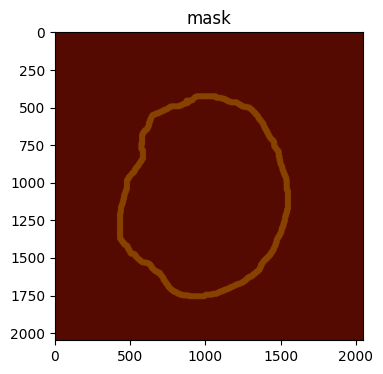

In [4]:
# Manually load mask
# mask_path = Path('./manual_masking_images/KDNA_11.png')
# mask_path = Path('./manual_masking_images/KPN001_07.png')
# mask_path = Path('./manual_masking_images/KPN001_09.png')
# mask_path = Path('./manual_masking_images/KPN001_20.png')
# mask_path = Path('./manual_masking_images/KPN001_27.png')
# mask_path = Path('./manual_masking_images/KPN004_06.png')
# mask_path = Path('./manual_masking_images/KPN004_09.png')
# mask_path = Path('./manual_masking_images/KPN005_19.png')
# mask_path = Path('./manual_masking_images/KPN005_24.png')
mask_path = Path('./manual_masking_images/KPN005_26.png')

mask = imread(mask_path)
mask = mask.astype(bool)
print(mask.shape)
plot(mask, title='mask', figsize=(4, 4))

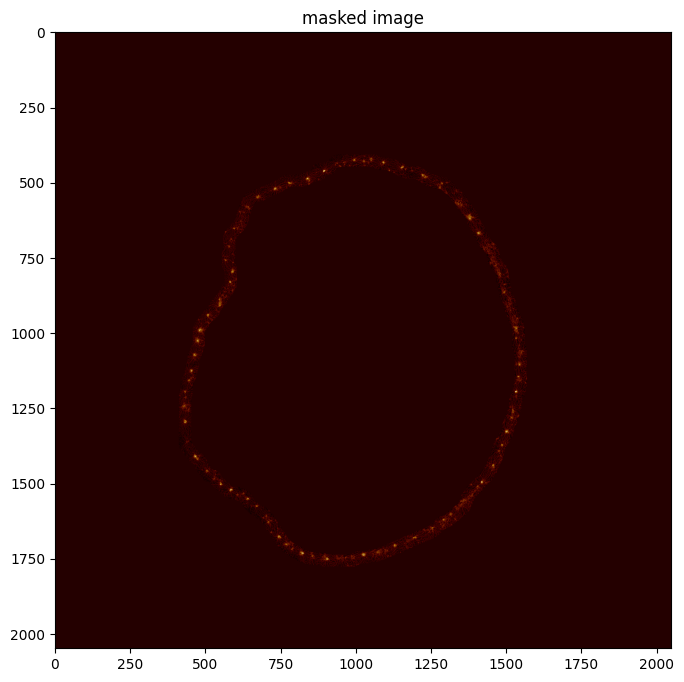

In [5]:
# Apply the mask to the image
masked = np.ma.masked_array(data=image, mask=np.invert(mask), fill_value=0).filled()
plot(masked, title='masked image', zlimit=False)

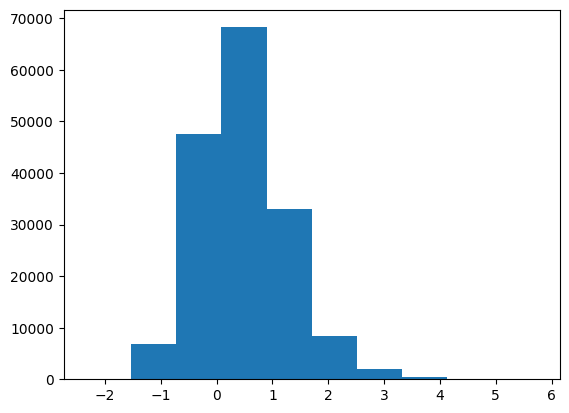

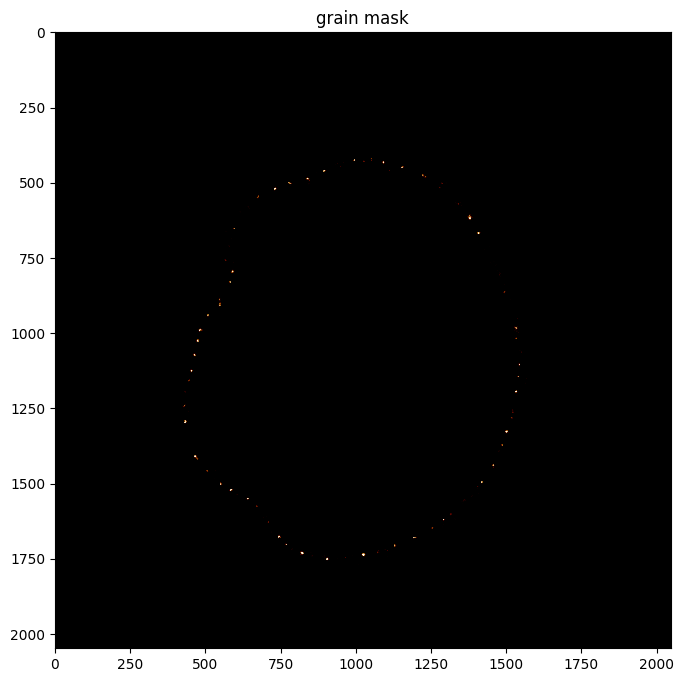

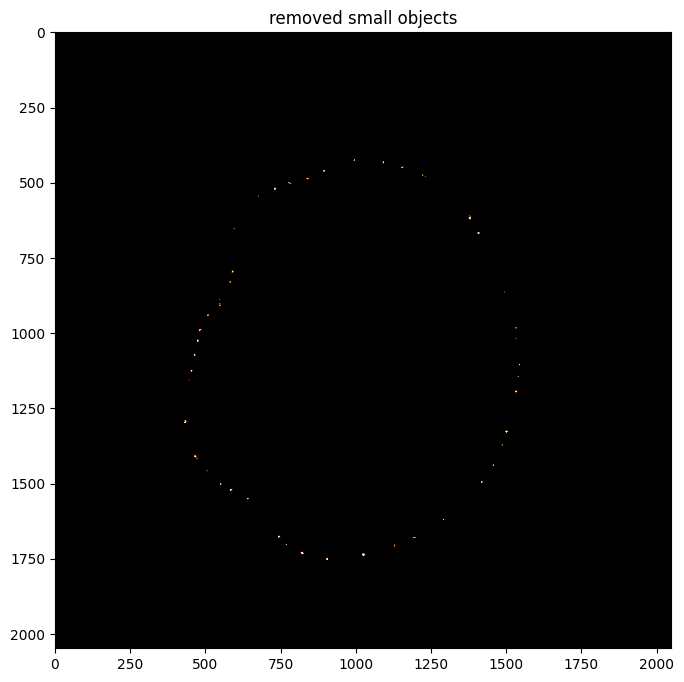

In [6]:
# mask the image within the defined masked region for nodes

std_dev_multiplier = 10
plt.hist(masked[masked != 0.0])
threshold = np.mean(masked[masked != 0.0]) + np.std(masked) * std_dev_multiplier
grain_mask = masked > threshold
plot(grain_mask, title='grain mask', zlimit=False)
removed_small_objects = remove_small_objects(grain_mask, 15)
plot(removed_small_objects, title='removed small objects', zlimit=False)
labelled = label(removed_small_objects)
#coloured_labels = label2rgb(labelled, bg_label=0)
#plot(coloured_labels, title='labelled')

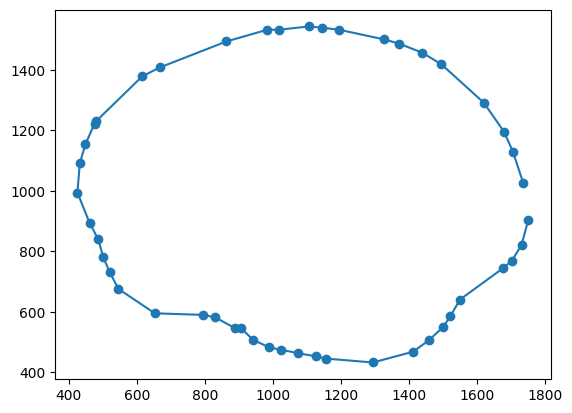

In [7]:
def get_points(binary_img) -> tuple:
    labelled = label(binary_img)
    regions = regionprops(labelled)
    points = np.ndarray((len(regions), 2))
    for props_index, props in enumerate(regions):
        points[props_index, :] = props.centroid

    return points

points = get_points(labelled)

centroid = np.array([np.mean(points[:, 0]), np.mean(points[:, 1])])

# Function to find angle of point from centroid
def angle(point, centroid):
    dx, dy = point - centroid
    return (np.arctan2(dy, dx) + 2 * np.pi) % (2 * np.pi)

# Sort the points based on their angles around the centroid
sorted = points[np.argsort([angle(point, centroid) for point in points])]


xs = np.append(sorted[:, 1], sorted[0, 1])
ys = np.append(sorted[:, 0], sorted[0, 0])

plt.scatter(sorted[:, 0], sorted[:, 1])
plt.plot(sorted[:, 0], sorted[:, 1])

In [8]:
def region_stats(labelled_image: np.ndarray, image: np.ndarray):

    region_props = regionprops(label_image=labelled_image)
    areas = np.zeros(len(region_props))
    volumes = np.zeros(len(region_props))
    max_heights = np.zeros(len(region_props))
    mean_heights = np.zeros(len(region_props))
    for props_index, props in enumerate(region_props):
        areas[props_index] = props.area
        region_points = np.where(labelled_image == props.label)
        region_values = image[region_points]
        volume = np.sum(region_values)
        volumes[props_index] = volume
        max_heights[props_index] = np.max(region_values)
        mean_heights[props_index] = np.mean(region_values)

    return {
        'areas': areas,
        'volumes': volumes,
        'max_heights': max_heights,
        'mean_heights': mean_heights,
        'number_of_regions': len(region_props),
    }

In [9]:
from network_stats import network_feret_diameters, get_triangle_height, is_clockwise, network_area, polygon_perimeter, interpolate_and_get_curvature

In [10]:
#Output statistics

MICRON_SCALING_FACTOR = 0.001
P_TO_MICRON = p_to_nm * MICRON_SCALING_FACTOR

print('Image:',file)

print('- molecule stats -')
area = network_area(sorted)* P_TO_MICRON**2
print(f'area: {area:.2f} μm^2')
perimeter = polygon_perimeter(sorted)* P_TO_MICRON
print(f'perimeter: {perimeter:.2f} μm')
min_feret, max_feret = network_feret_diameters(sorted)
print(f'min_feret: {min_feret* P_TO_MICRON:.2f} μm | max_feret: {max_feret* P_TO_MICRON:.2f} μm')
regionstats = region_stats(labelled_image=labelled, image=image)
# curvature_all_nodes = rim_curvature(sorted[:, 1], sorted[:, 0])
curvature_interpolated, curvature_all_nodes = interpolate_and_get_curvature(points=sorted, interpolation_number=10)
print(f'mean_curvature: {np.mean(curvature_all_nodes)}')
print(f'sum_curvature: {np.sum(curvature_all_nodes)}')

print('- node stats -')
num_perimeter_nodes = sorted.shape[0]
print(f'number of nodes in perimeter: {num_perimeter_nodes}')
print(f'node areas | min: {np.min(regionstats["areas"]* p_to_nm**2):.2f} nm^2 max: {np.max(regionstats["areas"]* p_to_nm**2):.2f} nm^2 mean: {np.mean(regionstats["areas"]* p_to_nm**2):.2f} nm^2')
print(f'node volumes | min: {np.min(regionstats["volumes"]* p_to_nm**2):.2f} nm^3 max: {np.max(regionstats["volumes"]* p_to_nm**2):.2f} nm^3 mean: {np.mean(regionstats["volumes"]* p_to_nm**2):.2f} nm^3')
print(f'mean node height values | min: {np.min(regionstats["mean_heights"]):.2f} nm max: {np.max(regionstats["mean_heights"]):.2f} nm mean: {np.mean(regionstats["mean_heights"]):.2f} nm')
print(f'max node height values | min: {np.min(regionstats["max_heights"]):.2f} nm max: {np.max(regionstats["max_heights"]):.2f} nm mean: {np.mean(regionstats["max_heights"]):.2f} nm\n')

print('Full Curvature Values:')
print(curvature_all_nodes,"\n")
print("---------------------------------------------------------------")

Image: Folded/20230126_KPN005.0_00026.spm
- molecule stats -
area: 35.01 μm^2
perimeter: 21.56 μm
min_feret: 6.03 μm | max_feret: 7.51 μm
mean_curvature: 0.013807569287219318
sum_curvature: 0.6489557564993079
- node stats -
number of nodes in perimeter: 47
node areas | min: 508.89 nm^2 max: 3021.54 nm^2 mean: 1381.85 nm^2
node volumes | min: 1441.18 nm^3 max: 9250.45 nm^3 mean: 4229.48 nm^3
mean node height values | min: 2.57 nm max: 3.65 nm mean: 3.03 nm
max node height values | min: 2.90 nm max: 5.74 nm mean: 4.36 nm

Full Curvature Values:
[0.0004574  0.00472497 0.00932219 0.0072946  0.00648305 0.01259241
 0.00897707 0.00281716 0.00429151 0.0039457  0.01494796 0.00776552
 0.0130726  0.00278815 0.00253688 0.00855978 0.00179869 0.00766373
 0.00872756 0.01078018 0.02120187 0.00549899 0.01691766 0.0122894
 0.00469626 0.02266662 0.02373457 0.00690754 0.0280506  0.04781781
 0.10456549 0.03314307 0.02970778 0.0018718  0.00259794 0.00408615
 0.00520094 0.01524783 0.01902594 0.01059788 0.021

47
47


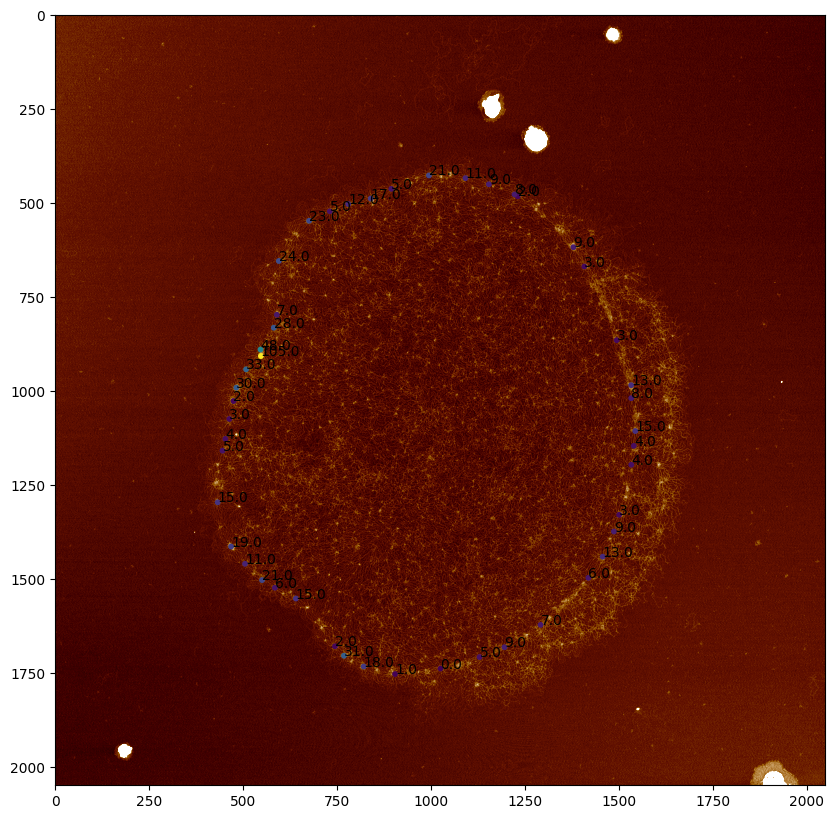

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image, cmap=cmap, vmin=-3, vmax=4)
# plt.plot(sorted[:, 1], sorted[:, 0])
min_curvature = np.min(curvature_all_nodes)
max_curvature = np.max(curvature_all_nodes)
range_curvature = max_curvature - min_curvature
colour_multiplier = 1 / range_curvature
colours = curvature_all_nodes * colour_multiplier
print(len(sorted))
print(len(colours))
# height_capped_curvatures = np.clip(curvature_all_nodes, 0, 0.01)
ax.scatter(sorted[:, 1], sorted[:, 0], c=curvature_all_nodes, s=10)
for index, node in enumerate(sorted):
    plt.text(node[1], node[0], f'{np.around(curvature_all_nodes[index]*1000, 0)}')
plt.show()